# 🌴 Decision Tree Regression (SKLearn & Custom)

In this notebook, we explore Decision Tree regression using:

- **Synthetic data** with Gaussian noise
- **SKLearn's `DecisionTreeRegression`**
- A **custom implementation of a binary decision tree**
  
Evaluation metrics and visualizations are included to compare both implementations.

In [96]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

## 🛠️ Utils

In [97]:
def evaluate_regression(
    y_true: NDArray[np.float64], y_pred: NDArray[np.float64]
) -> dict[str, float]:
    """Compute and print regression evaluation metrics.

    Args:
        y_true (NDArray[np.float64]): True target values.
        y_pred (NDArray[np.float64]): Predicted target values.

    Returns:
        dict[str, float]: MAE, MSE, and R² score.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{Fore.CYAN}Mean Absolute Error (MAE):{Style.RESET_ALL} {mae:.4f}")
    print(f"{Fore.CYAN}Mean Squared Error (MSE):{Style.RESET_ALL} {mse:.4f}")
    print(f"{Fore.CYAN}R² Score:{Style.RESET_ALL} {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

In [98]:
def plot_regression_results(
    x: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
    y_pred: NDArray[np.float64],
    w: float,
    b: float,
    title: str = "Regression Plot",
) -> None:
    """Plot noisy data points, model predictions, and the original regression line.

    Args:
        x (NDArray[np.float64]): Full input features used to generate noisy data.
        y (NDArray[np.float64]): Noisy target values.
        X_test (NDArray[np.float64]): Test feature values used for predictions.
        y_pred (NDArray[np.float64]): Predicted values from the regression model.
        w (float): True slope of the underlying model (for reference line).
        b (float): True intercept of the underlying model.
        title (str): Title of the plot. Default is "Regression Plot".
    """
    x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_line = b + x_range * w

    sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")
    sns.lineplot(
        x=X_test.flatten(),
        y=y_pred.flatten(),
        color="red",
        label="Regression line (prediction)",
    )
    sns.lineplot(
        x=x_range.flatten(),
        y=y_line.flatten(),
        color="green",
        label="Original regression line (no noise)",
    )
    plt.title(title)
    plt.legend()
    plt.show()

## 📊 Generate Dataset

In [99]:
def generate_data(
    n: int, w: float, b: float, noise_level: float = 1.0, seed: int = 42
) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Generate synthetic linear data with Gaussian noise.

    Args:
        n (int): Number of data points to generate.
        w (float): Slope of the linear function.
        b (float): Intercept of the linear function.
        noise_level (float): Standard deviation of Gaussian noise added to the data.
        seed (int): Seed for the random number generator.

    Returns:
        tuple[NDArray[np.float64], NDArray[np.float64]]: Tuple containing the list of x
        values and corresponding noisy y values.
    """
    rng = np.random.default_rng(seed)
    x = rng.uniform(0, 25, n)
    y = w * x + b + rng.normal(0, noise_level, n)
    return x, y


# Set true parameters of the linear relationship
w = 2.5  # Slope coefficient
b = 1.5  # Intercept (bias term)

# Generate dataset
x, y = generate_data(n=1000, w=w, b=b, noise_level=4.5)

In [100]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Convert lists to numpy arrays with correct shape for sklearn
X_train_np = np.array(X_train).reshape(-1, 1)
X_test_np = np.array(X_test).reshape(-1, 1)

## ⚙️ SKLearn Model

In [101]:
# Create and train the model
model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train_np, y_train)

# Predict on test data
predicted = model.predict(X_test_np)

In [102]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 4.3314
Mean Squared Error (MSE): 28.6217
R² Score: 0.9237


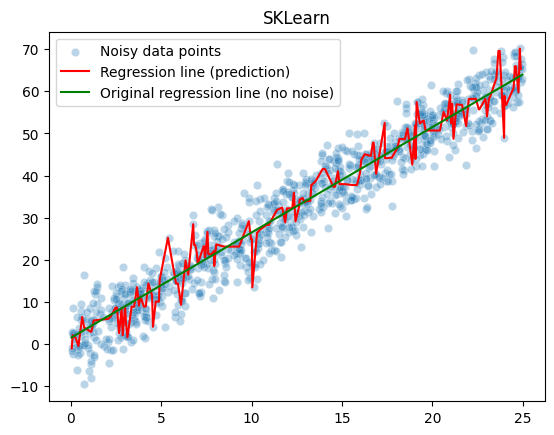

In [103]:
plot_regression_results(x, y, X_test, predicted, w, b, "SKLearn")

## 🧪 Simple binary decision tree regression

In [104]:
class Node:
    """A node in the decision tree.

    Attributes:
        value (int | None): Class label if the node is a leaf, otherwise None.
        feature (int | None): Index of the feature to split on at this node.
        threshold (float | None): Threshold value for the split.
        left (Node | None): Left child node.
        right (Node | None): Right child node.
    """

    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        value: float | None = None,
    ) -> None:
        """Initialize a decision tree node.

        Args:
            feature (int | None): Feature index to split on, if applicable.
            threshold (float | None): Threshold value for the split, if applicable.
            value (float  | None): Class label for a leaf node.
        """
        self.value: float | None = value
        self.feature: int | None = feature
        self.threshold: float | None = threshold
        self.left: "Node" | None = None
        self.right: "Node" | None = None


class MyDecisionTreeRegressor:
    """A simple binary decision tree regressor.

    This regressor recursively splits the data to minimize the impurity and
    forms a binary tree for classification.

    Attributes:
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an
            internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
        max_features (int | float | Literal["sqrt", "log2"] | None, optional):
            Number or fraction of features to consider when looking for the
            best split. If None, use all features. If 'sqrt', use sqrt(n_features).
            If 'log2', use log2(n_features). If float, selects that fraction of
            total features. If int, selects exactly `max_features` features.
            Defaults to None.
        min_impurity_decrease (float): A node will be split if the impurity
            decrease is at least this value.
        rng (Generator): NumPy random number generator instance.
        root (Node | None): Root node of the decision tree.
    """

    def __init__(
        self,
        max_depth: int,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: int | float | Literal["sqrt", "log2"] | None = None,
        min_impurity_decrease: float = 0.0,
        random_state: int | None = None,
    ) -> None:
        """Initialize the decision tree regressor.

        Args:
            max_depth (int): Maximum allowed depth of the tree.
            min_samples_split (int, optional): Minimum number of samples required to
                split an internal node. Defaults to 2.
            min_samples_leaf (int, optional): Minimum number of samples required to be
                at a leaf node. Defaults to 1.
            max_features (int | float | Literal["sqrt", "log2"] | None, optional):
                Number or fraction of features to consider when looking for the
                best split. If None, use all features. If 'sqrt', use sqrt(n_features).
                If 'log2', use log2(n_features). If float, selects that fraction of
                total features. If int, selects exactly `max_features` features.
                Defaults to None.
            min_impurity_decrease (float, optional): Minimum impurity decrease
                required to make a split. Defaults to 0.0.
            random_state (int | None, optional): Random seed for reproducibility.
                Defaults to None.
        """
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.max_features: int | float | str | None = max_features
        self.min_impurity_decrease: float = min_impurity_decrease
        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.root: Node | None = None

    def _get_features(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Select a subset of feature indices based on the `max_features` parameter.

        This method determines how many features to consider at each split based on
        the type and value of `max_features`:
            - If int, selects exactly `max_features` features.
            - If float, selects that fraction of total features.
            - If 'sqrt', selects sqrt(n_features).
            - If 'log2', selects log2(n_features).
            - If None: use all features.

        Ensures at least one feature is selected and does not exceed the number
        of available features.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Array of selected feature indices.

        Raises:
            ValueError: If `max_features` is not an int, float, "sqrt", or "log2".
        """
        feature_count = X.shape[1]

        if isinstance(self.max_features, int):
            feature_count = self.max_features
        elif isinstance(self.max_features, float):
            feature_count = int(feature_count * self.max_features)
        elif self.max_features == "sqrt":
            feature_count = int(np.sqrt(feature_count))
        elif self.max_features == "log2":
            feature_count = int(np.log2(feature_count))
        elif self.max_features is not None:
            raise ValueError(f"Unsupported max_features: {self.max_features}")

        feature_count = max(1, min(feature_count, X.shape[1]))
        return self.rng.choice(X.shape[1], feature_count, replace=False)

    def _squared_error(self, y: NDArray[np.float64]) -> float:
        """Compute the mean squared error (variance) of the target values.

        Args:
            y (NDArray[np.float64]): Array of target values.

        Returns:
            float: Mean squared error (variance) of the values.
        """
        if len(y) == 0:
            return 0.0

        return np.mean((y - np.mean(y)) ** 2)

    def _split_dataset(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        feature_index: int,
        threshold: float,
    ) -> tuple[
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
    ]:
        """Split the dataset based on a feature and a threshold.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.
            feature_index (int): Index of the feature to split on.
            threshold (float): Threshold value for the split.

        Returns:
            Tuple of:
                X_left (NDArray[np.float64]): Features where feature <= threshold.
                y_left (NDArray[np.float64]): Labels for X_left.
                X_right (NDArray[np.float64]): Features where feature > threshold.
                y_right (NDArray[np.float64]): Labels for X_right.
        """
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _best_split(
        self, X: NDArray[np.float64], y: NDArray[np.float64]
    ) -> tuple[int, float]:
        """Find the best feature and threshold to split the dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.

        Returns:
            tuple[int, float]: Best feature index and corresponding threshold.
        """
        best_feature: int | None = None
        best_threshold: float | None = None
        best_impurity: float = float("-inf")

        current_impurity = self._squared_error(y)

        for feature_index in self._get_features(X):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                _, y_left, _, y_right = self._split_dataset(
                    X, y, feature_index, threshold
                )
                if (
                    len(y_left) < self.min_samples_leaf
                    or len(y_right) < self.min_samples_leaf
                ):
                    continue

                left_impurity = self._squared_error(y_left)
                right_impurity = self._squared_error(y_right)
                weighted_impurity = (
                    len(y_left) * left_impurity + len(y_right) * right_impurity
                ) / len(y)
                impurity_decrease = current_impurity - weighted_impurity
                if (
                    impurity_decrease <= best_impurity
                    or impurity_decrease < self.min_impurity_decrease
                ):
                    continue

                best_impurity = impurity_decrease
                best_threshold = threshold
                best_feature = feature_index

        return best_feature, best_threshold

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Train the decision tree on the provided dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.float64]): Labels of shape (n_samples,).
        """
        self.root = self.build(X, y)

    def build(
        self, X: NDArray[np.float64], y: NDArray[np.float64], depth: int = 0
    ) -> Node:
        """Recursively build the decision tree.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Labels.
            depth (int, optional): Current depth of the tree. Defaults to 0.

        Returns:
            Node: Root node of the constructed subtree.
        """
        if (
            len(np.unique(y)) == 1
            or len(y) < self.min_samples_split
            or depth == self.max_depth
        ):
            return Node(value=np.mean(y))

        feature, threshold = self._best_split(X, y)
        if feature is None:
            return Node(value=np.mean(y))

        X_left, y_left, X_right, y_right = self._split_dataset(X, y, feature, threshold)

        node = Node(feature=feature, threshold=threshold)
        node.left = self.build(X_left, y_left, depth + 1)
        node.right = self.build(X_right, y_right, depth + 1)

        return node

    def _predict_one(self, x: NDArray[np.float64], node: Node | None = None) -> int:
        """Predict the label for a single data point.

        Args:
            x (NDArray[np.float64]): Input feature vector.
            node (Node | None, optional): Current node in the tree. Defaults to root.

        Returns:
            int: Predicted class label.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict the labels for a batch of input samples.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted labels for each sample.
        """
        return np.array([self._predict_one(x) for x in X])

In [105]:
# Create and train the model
model = MyDecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train_np, y_train)

# Predict on test data
predicted = model.predict(X_test_np)

In [106]:
_ = evaluate_regression(y_test, predicted)

Mean Absolute Error (MAE): 4.8107
Mean Squared Error (MSE): 35.3486
R² Score: 0.9058


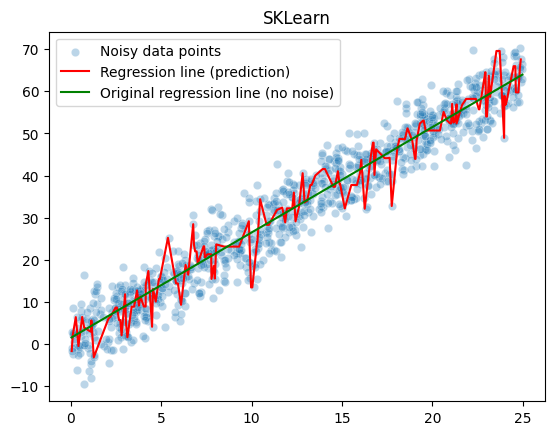

In [107]:
plot_regression_results(x, y, X_test, predicted, w, b, "SKLearn")